<a href="https://colab.research.google.com/github/celestial-shubham/Image-Dehazing-Project/blob/main/ImageDehazing_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import numpy as np
import os #, shutil
from tensorflow.keras.layers import *
import glob
import random
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Hyperparameters**

In [ ]:
n_epochs = 10
batch_size = 8
learning_rate = 1e-4
weight_decay = 1e-4

# K-Estimation Module

In [ ]:
def Aod_net(X):
  
  c1 = Conv2D(3,1,1,padding="SAME",activation="relu",kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
  
  c2 = Conv2D(3,3,1,padding="SAME",activation="relu",kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(c1)
  
  c1c2 = tf.concat([c1,c2],axis=-1)
  
  c3 = Conv2D(3,5,1,padding="SAME",activation="relu",kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(c1c2)
  
  c2c3 = tf.concat([c2,c3],axis=-1)
  
  c4 = Conv2D(3,7,1,padding="SAME",activation="relu",kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(c2c3)
  
  c1c2c3c4 = tf.concat([c1,c2,c3,c4],axis=-1)
  
  c5 = Conv2D(3,3,1,padding="SAME",activation="relu",kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(c1c2c3c4)
  
  K = c5
  
  output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
  
  return output

# **Data Loading & Pre-processing**

In [ ]:
def setup_data_paths(orig_images_path,hazy_images_path):
  
  orig_image_paths = glob.glob(orig_images_path + "/*.jpg")
  n = len(orig_image_paths) 
  random.shuffle(orig_image_paths)
  
  train_keys = orig_image_paths[:int(0.90*n)]
  val_keys = orig_image_paths[int(0.90*n):]
  
  
  split_dict = {}
  for key in train_keys:
    split_dict[key] = 'train'
  for key in val_keys:
    split_dict[key] = 'val'
  
  train_data = []
  val_data = []
  
  hazy_image_paths = glob.glob(hazy_images_path + "/*.jpg")
  for path in hazy_image_paths:
    label = path.split('/')[-1]
    orig_path = orig_images_path + "/" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
    if(split_dict[orig_path] == 'train'):
      train_data.append([path,orig_path])
    else: val_data.append([path,orig_path])
  
  return train_data, val_data
  

In [ ]:
def load_image(X):
  raw = tf.io.read_file(X)
  x= tf.image.decode_jpeg(raw,channels=3)
  X = tf.image.resize(x,(480,640))
  X = X / 255.0
  return X

def showImage(x):
  x = np.asarray(x*255,dtype=np.int32)
  plt.figure()
  plt.imshow(x)
  plt.show()

In [ ]:
def create_datasets(train_data,val_data,batch_size):
  
  train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
  train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
  train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(100).repeat().batch(batch_size)

  val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
  val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
  val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(100).repeat().batch(batch_size)
  
  iterator = tf.data.Iterator.from_structure(tf.data.get_output_types(train_ds),tf.data.get_output_shapes(train_ds))
  
  train_init_op = iterator.make_initializer(train_ds)
  val_init_op = iterator.make_initializer(val_ds)
  
  return train_init_op, val_init_op, iterator


# **Training**

In [ ]:
np.random.seed(9999)
ops.reset_default_graph()
train_data, val_data = setup_data_paths(orig_images_path="/content/gdrive/MyDrive/AOD-Dataset/orig_images", hazy_images_path="/content/gdrive/MyDrive/AOD-Dataset/hazy_images");
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = Aod_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


In [ ]:
saver = tf.train.Saver()
load_path = None

with tf.device('/gpu:0'):
  with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
      
      sess.run(train_init_op)
      batches = len(train_data) // batch_size
      epoch_loss = 0.0
      for batch in range(batches):

        batch_data = sess.run(next_element)
        batch_loss, _ = sess.run([loss,optimizer],feed_dict={X:batch_data[0],Y:batch_data[1]})
        epoch_loss += batch_loss / float(batches)
        if batch % 1000 == 0:
          print("Training loss at batch %d: %f\n"%(batch,batch_loss))
            
      train_loss = epoch_loss

      sess.run(val_init_op)
      batches= len(val_data) // batch_size
      epoch_loss = 0.0
      for batch in range(batches):
        batch_data = sess.run(next_element)
        batch_loss = sess.run(loss,feed_dict={X:batch_data[0],
                                             Y:batch_data[1]})
        epoch_loss += batch_loss / float(batches)
        if batch % 100 == 0:
          print("Validation loss at batch %d: %f\n"%(batch,batch_loss))
          for j in range(-2 + batch_size//2):
            x = batch_data[0][j].reshape((1,)+batch_data[0][j].shape)
            y = batch_data[1][j].reshape((1,)+batch_data[1][j].shape)
            dehazed_x = sess.run(dehazed_X,feed_dict={X:x,Y:y})
            print("Image Number: %d\n"%(j))
            showImage(x[0])
            showImage(y[0])
            showImage(dehazed_x[0])
      val_loss = epoch_loss

      saver.save(sess,'./models/model_checkpoint_' + str(epoch) + '.h5')
      
      print("Epoch %d\nTraining loss: %f\nValidation loss: %f\n\n"%(epoch,train_loss,val_loss))
    

In [ ]:
next_element = iterator.get_next()

with tf.Session() as sess:
  sess.run(val_init_op)
  
  for i in range(10):
    batch_data = sess.run(next_element)
    for j in range(4):
      x = batch_data[0][j].reshape((1,)+batch_data[0][j].shape)
      #showImage(x)

## **Evaluation**

In [ ]:
tf.reset_default_graph()
train_data, val_data = setup_data_paths(orig_images_path="/content/gdrive/MyDrive/AOD-Dataset/orig_images",
                                        hazy_images_path = "/content/gdrive/MyDrive/AOD-Dataset/hazy_images");
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = Aod_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)


#Final Results 

In [ ]:
import pickle
pickle_out = open("img_model.pkl", mode = "wb") 
pickle.dump('/content/gdrive/MyDrive/AOD-Dataset/models/model_checkpoint_9.h5.data-00000-of-00001', pickle_out) 
pickle_out.close()

INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/AOD-Dataset/models/model_checkpoint_9.h5


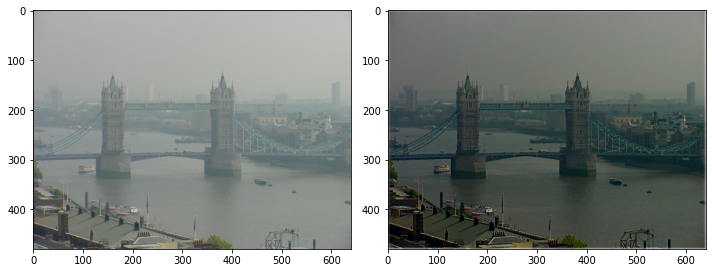

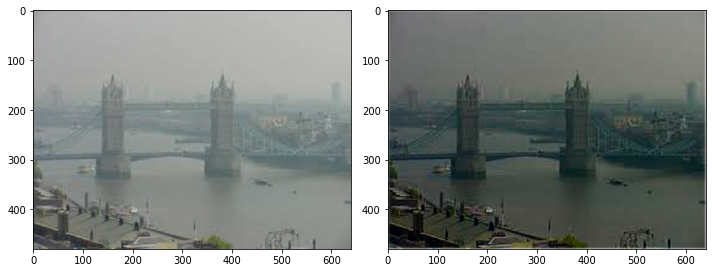

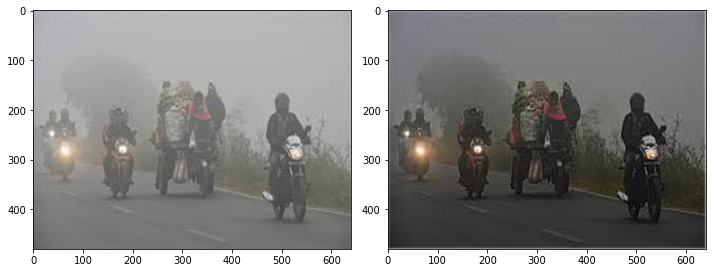

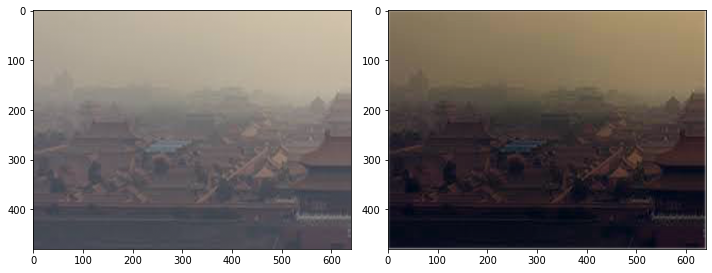

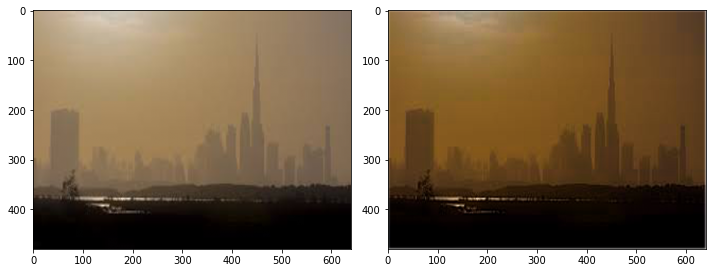

In [ ]:
saver = tf.train.Saver()


test_input_folder = "/content/gdrive/MyDrive/AOD-Dataset/test_images"
test_output_folder = "/content/gdrive/MyDrive/AOD-Dataset/dehazed_test_images"
if not os.path.exists(test_output_folder):
  os.mkdir(test_output_folder)
  
file_types = ['jpeg','jpg']

with tf.Session() as sess:
  saver.restore(sess,'/content/gdrive/MyDrive/AOD-Dataset/models/model_checkpoint_9.h5')
  test_image_paths = []
  for file_type in file_types:
    test_image_paths.extend(glob.glob(test_input_folder+"/*."+file_type))
  
  
  for path in test_image_paths:
    image_label = path.split(test_input_folder)[-1][1:]
    image = Image.open(path)
    image = image.resize((640, 480))
    image = np.asarray(image) / 255.0
    image = image.reshape((1,) + image.shape)
    dehazed_image = sess.run(dehazed_X,feed_dict={X:image,Y:image})
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    axes[0].imshow(image[0])
    axes[1].imshow(dehazed_image[0])
    fig.tight_layout()
    
    dehazed_image = np.asarray(dehazed_image[0] * 255,dtype=np.uint8)
    mpl.image.imsave(test_output_folder + "/" + 'dehazed_' + image_label, dehazed_image)
    
  

In [ ]:

!pip install -q pyngrok

!pip install -q streamlit

!pip install -q streamlit_ace

     |████████████████████████████████| 747kB 7.4MB/s 
     |████████████████████████████████| 7.8MB 7.8MB/s 
     |████████████████████████████████| 112kB 53.4MB/s 
     |████████████████████████████████| 174kB 48.9MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 4.2MB 53.3MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 122kB 58.4MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
     |████████████████████████████████| 2.6MB 6.4MB/s 


In [ ]:
%%writefile app.py
import streamlit as st
import pickle
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import numpy as np
import os, shutil
from tensorflow.keras.layers import *
import glob
import random
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
tf.disable_v2_behavior()


p_in =open('img_model.pkl','rb') 
model = pickle.load(p_in)

# @st.cache(allow_output_mutation=True)



def main():
    
    st.title("Image Dehazing using ASM(Astmospheric Scattering Model) 👁")
    html_temp = """ 
    <div style ="background-color:tomato;padding:13px"> 
    <h2 style ="color:white;text-align:center;"> Image Dehazer</h2> 
    </div> 
    """

    # display the front end aspect
    st.markdown(html_temp, unsafe_allow_html = True) 


    st.write("## Upload your Image")
    
    uploaded_image = st.file_uploader("Choose a jpg image", type=["jpg", "jpeg"])

    if uploaded_image is not None:
        image = Image.open(uploaded_image)
        st.image(image, caption="Uploaded Image.", use_column_width=True)
        

        # Make sure image is RGB
        image = image.convert("RGB")
        image = image.resize((640, 480))
        image = np.asarray(image) / 255.0
        image = image.reshape((1,) + image.shape)
        # TODO: Fix image size if the instance is breaking
        # If image is over certain size
        # Resize image to certain size
        # Don't make the image too small 
        #st.write(image.size)
        
        if st.button("Make a prediction"):
          
          
          with st.spinner("Doing the math..."):
            
            st.image(custom_pred, caption="Image Dehazed", use_column_width=True)
          
          st.write("Image Dehazed !!!")
          
        
    
if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-06-29 13:35:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.223.73.198, 3.219.55.35, 3.224.116.172, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.223.73.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  16.5MB/s    in 0.8s    

2021-06-29 13:35:56 (16.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]



In [ ]:
# !unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://828c783ead51.ngrok.io


In [ ]:
!streamlit run /content/app.py

2021-06-29 13:45:11.134114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://104.198.8.192:8501

2021-06-29 13:45:12.581 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
  Stopping...
